# Module 1: Setup & Utility Functions

In [1]:
import os
import gc
import time
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = '/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images'

def ensure_dirs(paths):
    """Ensure directories exist"""
    for path in paths:
        os.makedirs(path, exist_ok=True)

def clear_gpu_cache():
    """Free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_history(history, model_name, folder="logs"):
    """Save loss/accuracy per epoch"""
    ensure_dirs([folder])
    np.save(os.path.join(folder, f"{model_name}_history.npy"), history)

def load_history(model_name, folder="logs"):
    """Load history for evaluation"""
    path = os.path.join(folder, f"{model_name}_history.npy")
    return np.load(path, allow_pickle=True).item()


## Loading dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maimunulkjisan/rice-leaf-dataset-from-mendeley-data")
path = kagglehub.dataset_download("maimunulkjisan/rice-leaf-dataset-from-mendeley-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-leaf-dataset-from-mendeley-data


# Module 2: Data Preparation

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

def get_dataloaders(data_dir='dataset/', image_size=224, batch_size=32, val_split=0.1):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomRotation(degrees=20),  # Added Data Augmentation: RandomRotation and ColorJitter
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    full_dataset = ImageFolder(data_dir, transform=transform)
    class_names = full_dataset.classes
    num_classes = len(class_names)

    val_size = int(val_split * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, class_names


# Module 3: Model Fetching Utility

In [4]:
import torchvision.models as models
import torch.nn as nn

def get_model(model_name, num_classes):
    base_model = None

    if model_name == "mobilenetv2":
        base_model = models.mobilenet_v2(weights=None)
        base_model.classifier[1] = nn.Linear(base_model.last_channel, num_classes)
        base_model.features[17].add_module("dropout", nn.Dropout(0.2))  # Added Dropout

    elif model_name == "resnet50":
        base_model = models.resnet50(weights=None)
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

    elif model_name == "efficientnetb0":
        base_model = models.efficientnet_b0(weights=None)
        base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return base_model


# Module 4: Training + Validation Loop

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

@torch.no_grad()
def predict_single(model, val_loader, device="cuda"):
    model.to(device)
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    for images, labels in tqdm(val_loader, desc="Predicting"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    y_probs = np.concatenate(all_probs)

    return y_true, y_pred, y_probs

def train_model(model, train_loader, val_loader, model_name, num_epochs=10, lr=5e-5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "training_time": 0,
        "params": count_parameters(model)
    }

    best_acc = 0.0
    ensure_dirs(["models"])

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        loop = tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc.item())

        tqdm.write(f"Train Acc:{epoch_acc:.4f}, Train Loss: {epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}")

        # Save best model
        if val_epoch_acc > best_acc:
            torch.save(model.state_dict(), f"models/{model_name}.pth")
            best_acc = val_epoch_acc

    total_time = time.time() - start_time
    history["training_time"] = total_time
    save_history(history, model_name)
    clear_gpu_cache()


# Module 5: Soft Voting Ensemble

In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def load_model(model_name, num_classes):
    model = get_model(model_name, num_classes)
    model.load_state_dict(torch.load(f"models/{model_name}.pth", map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_ensemble(val_loader, model_names, num_classes):
    models = [load_model(name, num_classes) for name in model_names]
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Ensemble Prediction"):
            inputs = inputs.to(device)
            probs = []

            for model in models:
                output = model(inputs)
                probs.append(F.softmax(output, dim=1))

            avg_prob = torch.stack(probs).mean(dim=0)
            preds = torch.argmax(avg_prob, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


# Module 6: Evaluation Metrics & Reports

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)

COLORS = ['blue', 'red', 'green', 'orange', 'purple']

def evaluate_model(y_true, y_pred, class_names, probs=None):
    print("\n=== Evaluation Report ===")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-score     : {f1:.4f}")

    print("\n--- Class-wise F1 Score ---")
    class_f1 = f1_score(y_true, y_pred, average=None)
    for cls, score in zip(class_names, class_f1):
        print(f"{cls:<15}: {score:.4f}")

    if probs is not None:
        try:
            y_true_bin = np.eye(len(class_names))[y_true]
            auc = roc_auc_score(y_true_bin, probs, average="macro", multi_class="ovr")
            print(f"\nROC-AUC (OvR): {auc:.4f}")
        except Exception as e:
            print(f"ROC-AUC Error: {e}")

    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def compare_training_logs(model_names, metric="loss", log_folder="logs"):
    plt.figure(figsize=(10, 6))
    for i, name in enumerate(model_names):
        hist = load_history(name, folder=log_folder)
        y = hist["train_loss"] if metric == "loss" else hist["train_acc"]
        plt.plot(y, label=f"{name} - train", color=COLORS[i % len(COLORS)])

        y_val = hist["val_loss"] if metric == "loss" else hist["val_acc"]
        plt.plot(y_val, linestyle="--", label=f"{name} - val", color=COLORS[i % len(COLORS)])

    plt.title(f"Model {metric.title()} per Epoch")
    plt.xlabel("Epoch")
    ylabel = "Loss" if metric == "loss" else "Accuracy"
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def print_model_summary(model_names, log_folder="logs"):
    print("\n=== Model Summary ===")
    for name in model_names:
        hist = load_history(name, folder=log_folder)
        print(f"{name:<15} | Params: {hist['params']:,} | Training Time: {hist['training_time']:.2f}s")


# End-to-End Orchestration Script

In [8]:
# === Configuration ===
MODEL_NAMES = ["mobilenetv2", "resnet50", "efficientnetb0"]
NUM_EPOCHS = 15
BATCH_SIZE = 32

print(">>> Loading data...")
train_loader, val_loader, CLASSES = get_dataloaders(dataset_path, batch_size=BATCH_SIZE)
print(f"Total items: {len(train_loader.dataset) + len(val_loader.dataset)}")
print(f"Training items: {len(train_loader.dataset)}")
print(f"Validation items: {len(val_loader.dataset)}")
NUM_CLASSES = len(CLASSES)

# Train each model individually
for model_name in MODEL_NAMES:
    print(f"\n>>> Training {model_name.upper()}")
    model = get_model(model_name, NUM_CLASSES)
    train_model(model, train_loader, val_loader, model_name, num_epochs=NUM_EPOCHS)



>>> Loading data...
Total items: 5932
Training items: 5339
Validation items: 593

>>> Training MOBILENETV2


[mobilenetv2] Epoch 1/15: 100%|██████████| 167/167 [01:09<00:00,  2.41it/s]


Train Acc:0.4812, Train Loss: 1.1573, Val Acc: 0.5953, Val Loss: 0.9875


[mobilenetv2] Epoch 2/15: 100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Train Acc:0.6374, Train Loss: 0.8615, Val Acc: 0.6644, Val Loss: 0.8426


[mobilenetv2] Epoch 3/15: 100%|██████████| 167/167 [01:08<00:00,  2.45it/s]


Train Acc:0.6870, Train Loss: 0.7548, Val Acc: 0.7150, Val Loss: 0.7225


[mobilenetv2] Epoch 4/15: 100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Train Acc:0.7114, Train Loss: 0.6937, Val Acc: 0.7116, Val Loss: 0.6765


[mobilenetv2] Epoch 5/15: 100%|██████████| 167/167 [01:07<00:00,  2.48it/s]


Train Acc:0.7230, Train Loss: 0.6569, Val Acc: 0.7352, Val Loss: 0.6480


[mobilenetv2] Epoch 6/15: 100%|██████████| 167/167 [01:07<00:00,  2.48it/s]


Train Acc:0.7419, Train Loss: 0.6220, Val Acc: 0.7690, Val Loss: 0.5685


[mobilenetv2] Epoch 7/15: 100%|██████████| 167/167 [01:07<00:00,  2.48it/s]


Train Acc:0.7565, Train Loss: 0.5852, Val Acc: 0.7454, Val Loss: 0.6237


[mobilenetv2] Epoch 8/15: 100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Train Acc:0.7640, Train Loss: 0.5697, Val Acc: 0.7673, Val Loss: 0.5733


[mobilenetv2] Epoch 9/15: 100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Train Acc:0.7689, Train Loss: 0.5571, Val Acc: 0.7791, Val Loss: 0.5328


[mobilenetv2] Epoch 10/15: 100%|██████████| 167/167 [01:07<00:00,  2.48it/s]


Train Acc:0.7775, Train Loss: 0.5412, Val Acc: 0.7791, Val Loss: 0.5535


[mobilenetv2] Epoch 11/15: 100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Train Acc:0.7964, Train Loss: 0.5079, Val Acc: 0.7538, Val Loss: 0.5906


[mobilenetv2] Epoch 12/15: 100%|██████████| 167/167 [01:08<00:00,  2.45it/s]


Train Acc:0.8039, Train Loss: 0.4979, Val Acc: 0.8280, Val Loss: 0.4599


[mobilenetv2] Epoch 13/15: 100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


Train Acc:0.8086, Train Loss: 0.4810, Val Acc: 0.8314, Val Loss: 0.4583


[mobilenetv2] Epoch 14/15: 100%|██████████| 167/167 [01:07<00:00,  2.47it/s]


Train Acc:0.8179, Train Loss: 0.4606, Val Acc: 0.8196, Val Loss: 0.4258


[mobilenetv2] Epoch 15/15: 100%|██████████| 167/167 [01:13<00:00,  2.26it/s]


Train Acc:0.8288, Train Loss: 0.4380, Val Acc: 0.8432, Val Loss: 0.4126

>>> Training RESNET50


[resnet50] Epoch 1/15: 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]


Train Acc:0.6162, Train Loss: 0.9336, Val Acc: 0.6138, Val Loss: 0.9449


[resnet50] Epoch 2/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.7426, Train Loss: 0.6465, Val Acc: 0.7521, Val Loss: 0.6292


[resnet50] Epoch 3/15: 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]


Train Acc:0.7906, Train Loss: 0.5437, Val Acc: 0.7622, Val Loss: 0.5337


[resnet50] Epoch 4/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.8133, Train Loss: 0.4858, Val Acc: 0.8128, Val Loss: 0.4726


[resnet50] Epoch 5/15: 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]


Train Acc:0.8232, Train Loss: 0.4655, Val Acc: 0.7723, Val Loss: 0.6728


[resnet50] Epoch 6/15: 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]


Train Acc:0.8397, Train Loss: 0.4235, Val Acc: 0.7976, Val Loss: 0.4898


[resnet50] Epoch 7/15: 100%|██████████| 167/167 [01:41<00:00,  1.64it/s]


Train Acc:0.8511, Train Loss: 0.3909, Val Acc: 0.8499, Val Loss: 0.4304


[resnet50] Epoch 8/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.8562, Train Loss: 0.3777, Val Acc: 0.8668, Val Loss: 0.3558


[resnet50] Epoch 9/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.8717, Train Loss: 0.3431, Val Acc: 0.8061, Val Loss: 0.6049


[resnet50] Epoch 10/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.8829, Train Loss: 0.3098, Val Acc: 0.8853, Val Loss: 0.3496


[resnet50] Epoch 11/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.8882, Train Loss: 0.3031, Val Acc: 0.8381, Val Loss: 0.5046


[resnet50] Epoch 12/15: 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]


Train Acc:0.8972, Train Loss: 0.2765, Val Acc: 0.8398, Val Loss: 0.4476


[resnet50] Epoch 13/15: 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]


Train Acc:0.9069, Train Loss: 0.2581, Val Acc: 0.8617, Val Loss: 0.4167


[resnet50] Epoch 14/15: 100%|██████████| 167/167 [01:40<00:00,  1.66it/s]


Train Acc:0.9093, Train Loss: 0.2502, Val Acc: 0.9359, Val Loss: 0.1927


[resnet50] Epoch 15/15: 100%|██████████| 167/167 [01:41<00:00,  1.65it/s]


Train Acc:0.9221, Train Loss: 0.2076, Val Acc: 0.9241, Val Loss: 0.1958

>>> Training EFFICIENTNETB0


[efficientnetb0] Epoch 1/15: 100%|██████████| 167/167 [01:13<00:00,  2.26it/s]


Train Acc:0.4471, Train Loss: 1.2214, Val Acc: 0.5329, Val Loss: 1.0836


[efficientnetb0] Epoch 2/15: 100%|██████████| 167/167 [01:13<00:00,  2.27it/s]


Train Acc:0.6586, Train Loss: 0.8655, Val Acc: 0.6712, Val Loss: 0.7626


[efficientnetb0] Epoch 3/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.7335, Train Loss: 0.6814, Val Acc: 0.7605, Val Loss: 0.5747


[efficientnetb0] Epoch 4/15: 100%|██████████| 167/167 [01:13<00:00,  2.26it/s]


Train Acc:0.7661, Train Loss: 0.5993, Val Acc: 0.7960, Val Loss: 0.5209


[efficientnetb0] Epoch 5/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.7883, Train Loss: 0.5329, Val Acc: 0.8179, Val Loss: 0.4711


[efficientnetb0] Epoch 6/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.8048, Train Loss: 0.4878, Val Acc: 0.8297, Val Loss: 0.4205


[efficientnetb0] Epoch 7/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.8118, Train Loss: 0.4685, Val Acc: 0.8297, Val Loss: 0.4252


[efficientnetb0] Epoch 8/15: 100%|██████████| 167/167 [01:13<00:00,  2.27it/s]


Train Acc:0.8354, Train Loss: 0.4242, Val Acc: 0.8600, Val Loss: 0.3675


[efficientnetb0] Epoch 9/15: 100%|██████████| 167/167 [01:13<00:00,  2.27it/s]


Train Acc:0.8444, Train Loss: 0.3989, Val Acc: 0.8600, Val Loss: 0.3592


[efficientnetb0] Epoch 10/15: 100%|██████████| 167/167 [01:13<00:00,  2.27it/s]


Train Acc:0.8560, Train Loss: 0.3741, Val Acc: 0.8870, Val Loss: 0.3017


[efficientnetb0] Epoch 11/15: 100%|██████████| 167/167 [01:13<00:00,  2.27it/s]


Train Acc:0.8616, Train Loss: 0.3600, Val Acc: 0.8651, Val Loss: 0.3194


[efficientnetb0] Epoch 12/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.8764, Train Loss: 0.3209, Val Acc: 0.8954, Val Loss: 0.2793


[efficientnetb0] Epoch 13/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.8813, Train Loss: 0.3112, Val Acc: 0.9157, Val Loss: 0.2667


[efficientnetb0] Epoch 14/15: 100%|██████████| 167/167 [01:13<00:00,  2.28it/s]


Train Acc:0.8766, Train Loss: 0.3107, Val Acc: 0.9005, Val Loss: 0.2540


[efficientnetb0] Epoch 15/15: 100%|██████████| 167/167 [01:13<00:00,  2.27it/s]


Train Acc:0.8816, Train Loss: 0.2998, Val Acc: 0.9174, Val Loss: 0.2134


>>> Predicting using Soft Voting Ensemble...


Ensemble Prediction: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]



>>> Evaluation for Ensemble Model:

=== Evaluation Report ===
Accuracy     : 0.9359
Precision    : 0.9433
Recall       : 0.9363
F1-score     : 0.9368

--- Class-wise F1 Score ---
Bacterialblight: 0.9456
Blast          : 0.8812
Brownspot      : 0.9245
Tungro         : 0.9959

=== Confusion Matrix ===


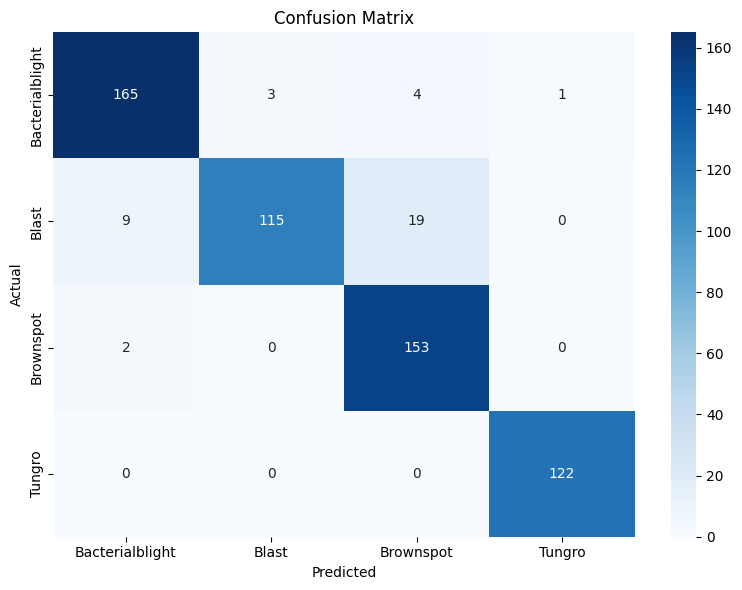

In [9]:
# Ensemble predictions
print(">>> Predicting using Soft Voting Ensemble...")
y_true, y_pred = predict_ensemble(val_loader, MODEL_NAMES, NUM_CLASSES)

# Evaluation
print("\n>>> Evaluation for Ensemble Model:")
evaluate_model(y_true, y_pred, class_names=CLASSES)


>>> Evaluation for MOBILENETV2:


Predicting: 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]



=== Evaluation Report ===
Accuracy     : 0.8196
Precision    : 0.8323
Recall       : 0.8205
F1-score     : 0.8240

--- Class-wise F1 Score ---
Bacterialblight: 0.7845
Blast          : 0.7143
Brownspot      : 0.8615
Tungro         : 0.9356

=== Confusion Matrix ===


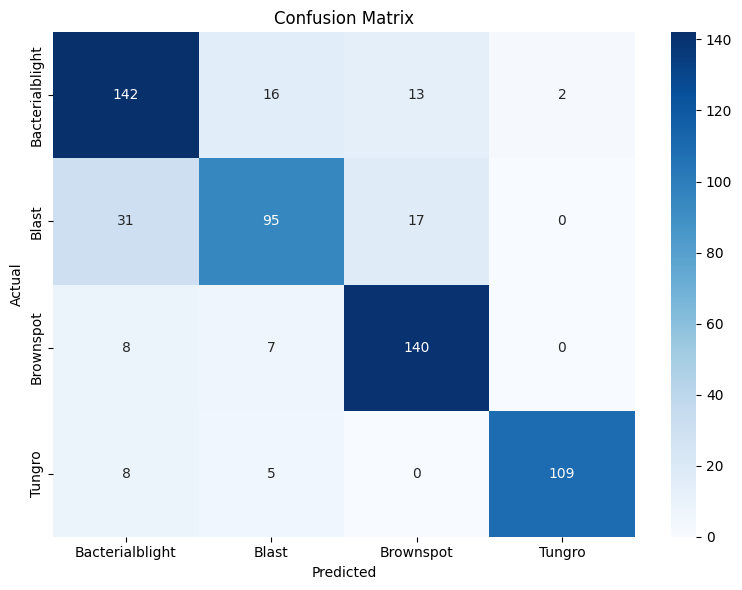


>>> Evaluation for RESNET50:


Predicting: 100%|██████████| 19/19 [00:06<00:00,  2.79it/s]


=== Evaluation Report ===
Accuracy     : 0.9174
Precision    : 0.9219
Recall       : 0.9197
F1-score     : 0.9193

--- Class-wise F1 Score ---
Bacterialblight: 0.9164
Blast          : 0.8657
Brownspot      : 0.9074
Tungro         : 0.9879

=== Confusion Matrix ===


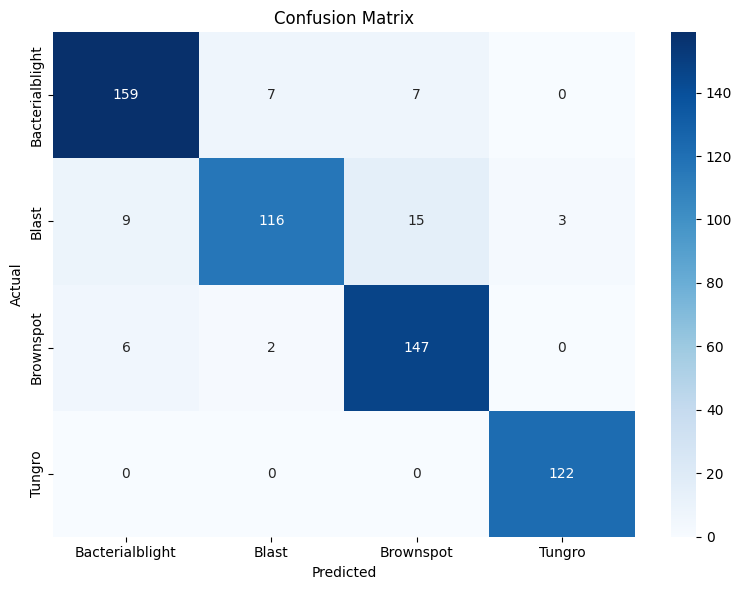


>>> Evaluation for EFFICIENTNETB0:


Predicting: 100%|██████████| 19/19 [00:06<00:00,  2.84it/s]



=== Evaluation Report ===
Accuracy     : 0.9089
Precision    : 0.9169
Recall       : 0.9098
F1-score     : 0.9102

--- Class-wise F1 Score ---
Bacterialblight: 0.9235
Blast          : 0.8340
Brownspot      : 0.8875
Tungro         : 0.9959

=== Confusion Matrix ===


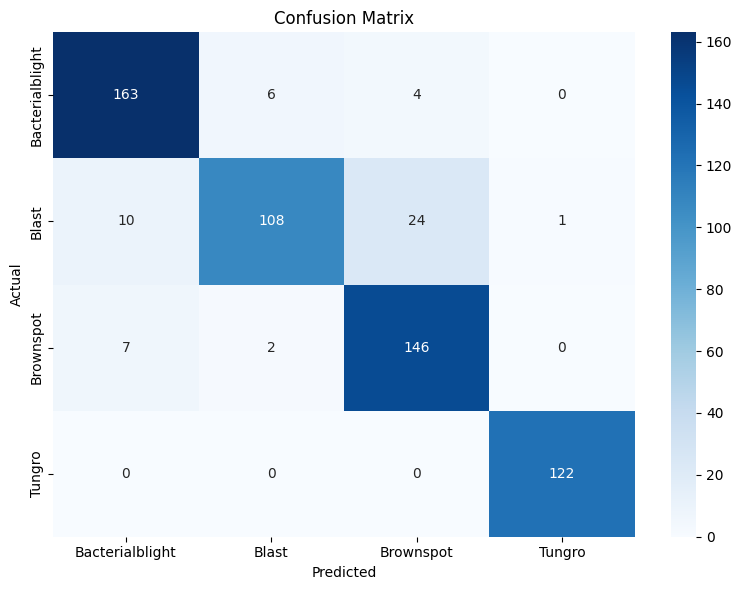

In [10]:
# Individual model metrics (Optional: Enable if needed)
for model_name in MODEL_NAMES:
    print(f"\n>>> Evaluation for {model_name.upper()}:")
    model = get_model(model_name, NUM_CLASSES)
    model.load_state_dict(torch.load(f"models/{model_name}.pth"))
    model.eval()
    y_true_ind, y_pred_ind, y_probs = predict_single(model, val_loader)
    evaluate_model(y_true_ind, y_pred_ind, CLASSES)

In [11]:
print_model_summary(MODEL_NAMES)


=== Model Summary ===
mobilenetv2     | Params: 2,228,996 | Training Time: 1112.80s
resnet50        | Params: 23,516,228 | Training Time: 1622.74s
efficientnetb0  | Params: 4,012,672 | Training Time: 1194.78s


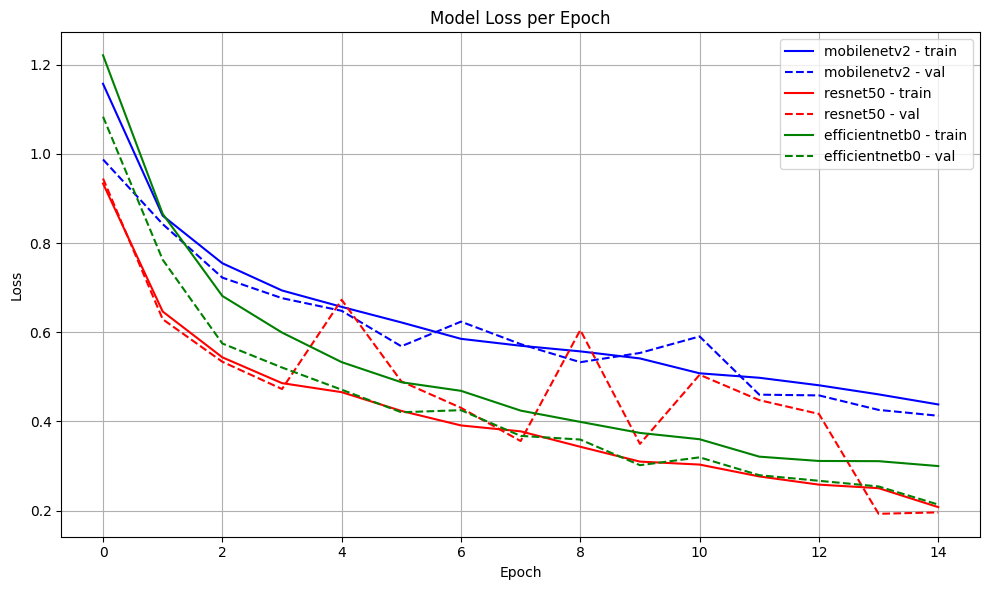

In [12]:
compare_training_logs(MODEL_NAMES, metric="loss")

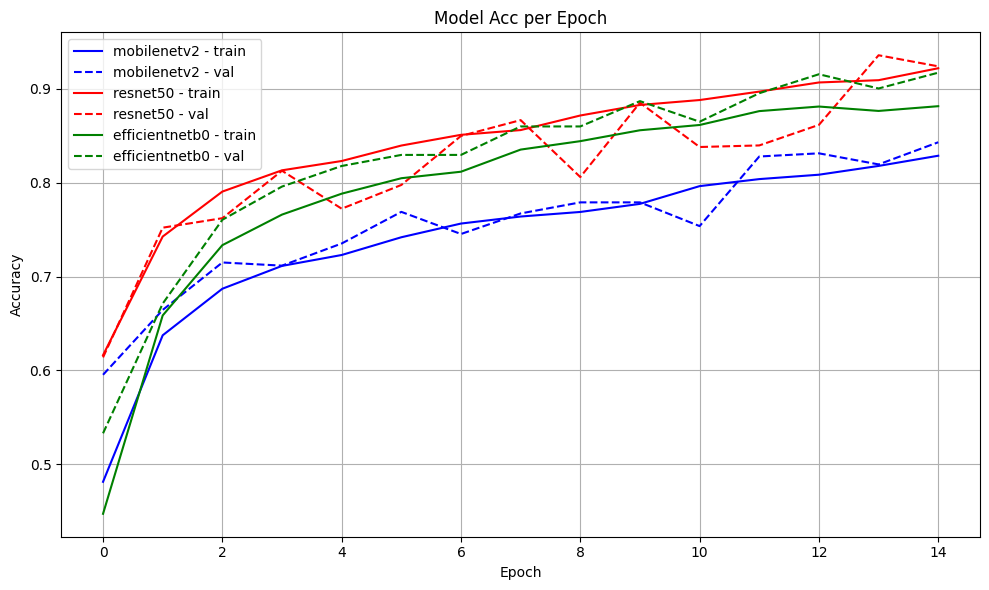

In [13]:
compare_training_logs(MODEL_NAMES, metric="acc")